# Crime and Neighborhoods of Tallinn, Estonia

## Applied Data Science Capstone Project

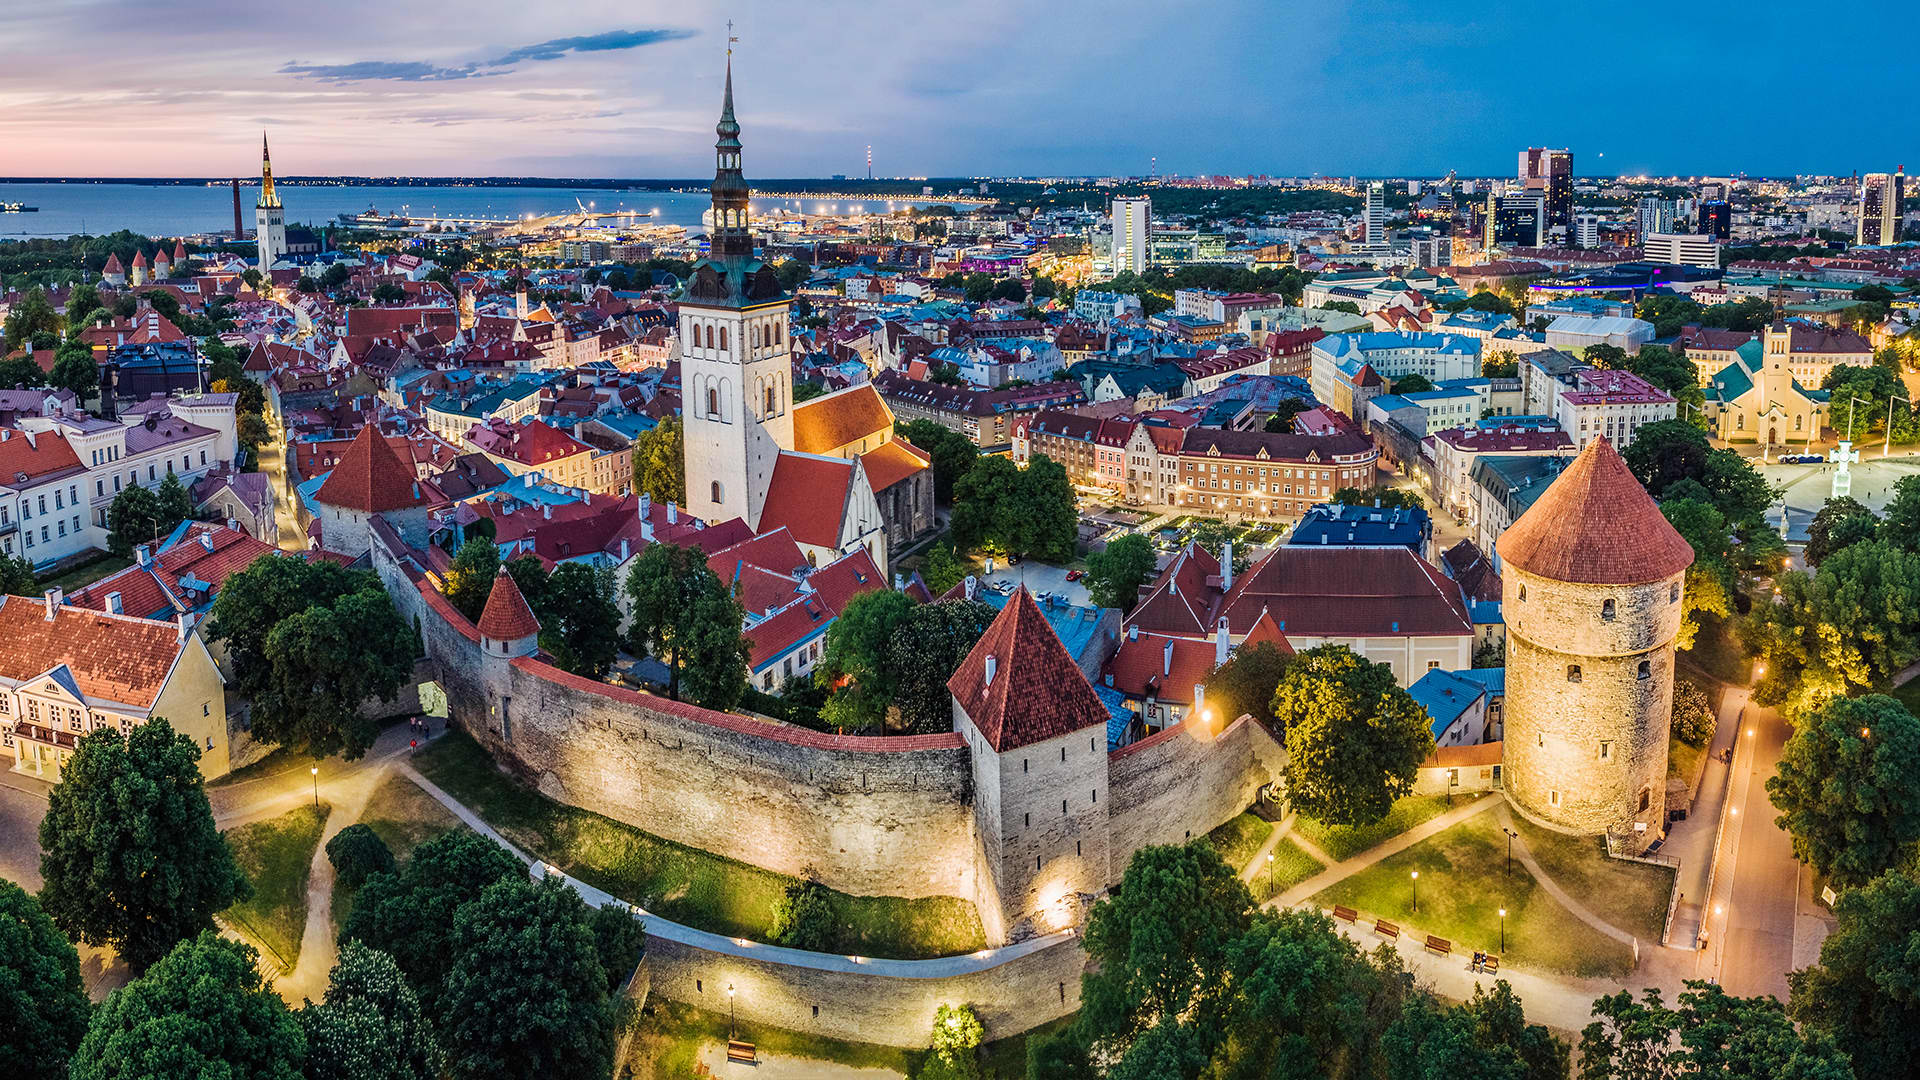

In [430]:
from PIL import Image
import requests
url = 'https://res.cloudinary.com/yit/image/upload/q_auto:eco,f_auto,fl_lossy,w_1920,c_limit/v1488395896/105552.jpg'
im = Image.open(requests.get(url, stream=True).raw)
im

## Description of the problem

Tallinn is the capital and most populous city of Estonia. Located in the northern part of the country, on the shore of the Gulf of Finland of the Baltic Sea, it has a population of ca 430 thousand. Tallinn is the main financial, industrial and cultural centre of Estonia. It is located 80 kilometres south of Helsinki, Finland, 320 kilometres west of Saint Petersburg, Russia, 301 kilometres north of Riga, Latvia, and 380 kilometres east of Stockholm, Sweden.
As Tallinn's Old Town is one of the best preserved medieval cities in Europe - it is listed as a UNESCO World Heritage Site - the whole city boasts at the same time with vibrant cultural and economic life. During the last 15 or so years, Tallinn has grown into being one of the best cities for start-up businesses, which sets new standards to the safety and security of the city to attract foreign talent.
One of the safety measures of a city is its crime rate. Although the number of crimes in Tallinn has declined considerably over the years, it is still worth to investigate, how the different districts compare to each other in this respect. So I will seek to answer the following questions:
1. What districts have the highest crime rate?
2. Which neighborhood data correlates to crime level?
3. Using Foursquare data, what venues are most common in the selected neighborhoods?

By definition, Tallinn is divided into eight districts which are further divided into 84 subdistricts or neighborhoods. My aim is to conduct the analysis on the neighborhood level.

## Data

Necessary data will be obtained from the following sources:
1. Estonian Open Data (crime data): https://avaandmed.eesti.ee
2. Tallinn in numbers (population data): https://www.tallinn.ee/eng/g2677s126569
3. Tallinn Geospatial Data (neighborhood geometry): https://www.tallinn.ee/est/geoportaal/Andmed
4. Statistics Estonia (income statistics): https://www.stat.ee/en
5. Foursquare Developers Access to venue data: https://foursquare.com/

Also, as local geospatial data is presented in Lambert coordinates, it is necessary convert them to WGS84 coordinates which shall be separately done with Estonian Land Board's application (https://www.maaamet.ee/rr/geo-lest/). 

Libraries to be used: pandas, geopandas, numpy, scipy, sklearn, matplotlib, seaborn, folium, geopy.

During the analysis I'll check if the data is clean, explore the data to understand the variables used, and then find the neighborhoods with highest crimes based on crime statistics in Tallinn and which are the most popular venues there. I will be using the geographical coordinates of Tallinn obtained from geocoder service, to plot the different neighborhoods, and finally cluster the neighborhoods and present the findings.

## Data loading, cleaning and wrangling 

Data for the particular analysis will be obtained from several sources, but will fall into the following main categories:
1. Crime data, including information on date, crime type, district and geolocation of the crime. Data source is Estonian Open Data, where the csv files on crimes committed in publice space and property crimes against property are availables. These two datasets were merged initally in Excel (including some operations like geocoordinates conversion and correction of words including vocals with "umlaut"s) and the downloaded to this notebook.
2. Neighborhood geometries, which were obtained from Tallinn geospatial open data.
3. Neighborhood data, including information on population and size of the neighborhoods (from Tallinn Open Data) and monthly income per neighborhood (from Estonian Statistics).

Main aim of data preparation was to associate the crimes with respective neighborhoods.
So, here we go.

In [431]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
!pip install geopandas
import geopandas as gpd
from scipy import stats
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

### 1. Crime data set

In [432]:
# loading the dataset with crime information, showing its first five rows
df_crime=pd.read_excel('/Users/andrihobemagi/Desktop/DataScience/09 Capstone Project/Alusandmed/crimes_tallinn.xlsx')
df_crime.head()

JuhtumId    ToimKpv  ToimKell ToimNadalapaev  \
0  fe3e6ede-2ee8-18d8-97ce-a370cdce960d 2020-07-16  17:30:00      Neljapäev   
1  fe3e6eb6-2ee8-18d8-97ce-a370cdce960d 2020-07-16  14:41:00      Neljapäev   
2  fe3e6eac-2ee8-18d8-97ce-a370cdce960d 2020-07-07  21:28:00      Teisipäev   
3  fe3e6e98-2ee8-18d8-97ce-a370cdce960d 2020-07-15  15:08:00      Kolmapäev   
4  fe3e6e84-2ee8-18d8-97ce-a370cdce960d 2020-07-21  21:56:00      Teisipäev   

  SyndmusLiikPuhas             Seadus Paragrahv  \
0           VARGUS  Karistusseadustik   Ā§ 199.   
1           VARGUS  Karistusseadustik   Ā§ 199.   
2           VARGUS  Karistusseadustik   Ā§ 199.   
3           VARGUS  Karistusseadustik   Ā§ 199.   
4        VANDALISM  Karistusseadustik   Ā§ 218.   

                                       ParagrahvTais   Loige Kahjusumma  \
0                                     Ā§ 199. Vargus  lg. 1.      0-499   
1                                     Ā§ 199. Vargus  lg. 2.      0-499   
2                                     Ā§ 199. Vargus  lg. 2.      0-499   
3                                     Ā§ 199. Vargus  lg. 2.      0-499   
4  Ā§ 218. Varavastane sĆ¼Ć¼tegu vĆ¤hevĆ¤Ć¤rtusli...  lg. 1.      0-499   

                           KohtLiik MaakondNimetus ValdLinnNimetus  \
0          AVALIK_KOHT,TANAV_VALJAK  Harju maakond         Tallinn   
1               AVALIK_KOHT,KAUPLUS  Harju maakond         Tallinn   
2               AVALIK_KOHT,KAUPLUS  Harju maakond         Tallinn   
3               AVALIK_KOHT,KAUPLUS  Harju maakond         Tallinn   
4  AVALIK_KOHT,SOIDUK_VA_UHISSOIDUK  Harju maakond         Tallinn   

  KohtNimetus   Latitude  Longitude     Lest_X    Lest_Y SyyteoLiik  
0    Kesklinn  59.438869  24.762218  6589250.0  543250.0         KT  
1    Kesklinn  59.438818  24.771029  6589250.0  543750.0         KT  
2    Kesklinn  59.434432  24.753308  6588750.0  542750.0         KT  
3    Kesklinn  59.438818  24.771029  6589250.0  543750.0         KT  
4    Lasnamäe  59.447362  24.841737  6590250.0  547750.0         VT

In [433]:
# checking the dataframe shape
df_crime.shape

(8195, 19)

In [434]:
# checking the null values in dataframe
df_crime.isnull().sum()

JuhtumId               1
ToimKpv                1
ToimKell             400
ToimNadalapaev         1
SyndmusLiikPuhas       0
Seadus                 1
Paragrahv              1
ParagrahvTais          1
Loige                  1
Kahjusumma          1050
KohtLiik               2
MaakondNimetus         1
ValdLinnNimetus        1
KohtNimetus            1
Latitude               1
Longitude             24
Lest_X                24
Lest_Y                24
SyyteoLiik             1
dtype: int64

In [435]:
# dropping the crimes without geospatial data
df_crime.dropna(subset=['Latitude','Longitude','Lest_X','Lest_Y'],axis=0,inplace=True)

In [436]:
# dropping all unnecessary columns
df_crime.drop(['Seadus','Paragrahv','ParagrahvTais','Loige','Kahjusumma','KohtLiik','ValdLinnNimetus','MaakondNimetus','SyyteoLiik'],axis=1,inplace=True)

In [437]:
# translating the remaining column headers to English
df_crime.rename({'JuhtumId': 'CaseId', 'ToimKpv': 'Date','ToimKell':'Time','ToimNadalapaev':'Weekday','SyndmusLiikPuhas':'CrimeType','KohtNimetus':'District'}, axis=1, inplace=True)

In [438]:
# checking the resulting dataframe
df_crime.head()

CaseId       Date      Time    Weekday  \
0  fe3e6ede-2ee8-18d8-97ce-a370cdce960d 2020-07-16  17:30:00  Neljapäev   
1  fe3e6eb6-2ee8-18d8-97ce-a370cdce960d 2020-07-16  14:41:00  Neljapäev   
2  fe3e6eac-2ee8-18d8-97ce-a370cdce960d 2020-07-07  21:28:00  Teisipäev   
3  fe3e6e98-2ee8-18d8-97ce-a370cdce960d 2020-07-15  15:08:00  Kolmapäev   
4  fe3e6e84-2ee8-18d8-97ce-a370cdce960d 2020-07-21  21:56:00  Teisipäev   

   CrimeType  District   Latitude  Longitude     Lest_X    Lest_Y  
0     VARGUS  Kesklinn  59.438869  24.762218  6589250.0  543250.0  
1     VARGUS  Kesklinn  59.438818  24.771029  6589250.0  543750.0  
2     VARGUS  Kesklinn  59.434432  24.753308  6588750.0  542750.0  
3     VARGUS  Kesklinn  59.438818  24.771029  6589250.0  543750.0  
4  VANDALISM  Lasnamäe  59.447362  24.841737  6590250.0  547750.0

In [439]:
# checking the shape after dropping null values: the are 24 crimes less, so not a significant loss to the dataset
df_crime.shape

(8171, 10)

In [440]:
# one more check on null values. as time will not be target of our analysis, we can retain these rows
df_crime.isnull().sum()

CaseId         0
Date           0
Time         397
Weekday        0
CrimeType      0
District       0
Latitude       0
Longitude      0
Lest_X         0
Lest_Y         0
dtype: int64

In [441]:
# checking the crime type counts with actual aim to follow up with the translation of crime types
df_crime['CrimeType'].value_counts()

VARGUS                              3249
PISIVARGUS                          2365
VANDALISM                           1142
JALGRATTA_MOPEEDI_VARGUS             363
KELMUS                               213
MOBIILTELEFONIVARGUS                 193
MUU                                  150
AVALIKU_KORRA_RIKKUMINE              141
KEHALINE_VAARKOHTLEMINE              135
KADUNUD_ESE/DOKUMENT                  80
MOOTORSOIDUKI_VARGUS                  66
ROOVIMINE                             43
TULEKAHJU                             19
POMMIAHVARDUS_KAHTLUS, PLAHVATUS      12
Name: CrimeType, dtype: int64

In [442]:
# replacing the crime types with English translation in the dataframe
df_crime['CrimeType'] = df_crime['CrimeType'].replace(['VARGUS','PISIVARGUS','VANDALISM','JALGRATTA_MOPEEDI_VARGUS','KELMUS','MOBIILTELEFONIVARGUS','MUU','AVALIKU_KORRA_RIKKUMINE','KEHALINE_VAARKOHTLEMINE','KADUNUD_ESE/DOKUMENT','MOOTORSOIDUKI_VARGUS','ROOVIMINE','TULEKAHJU','POMMIAHVARDUS_KAHTLUS, PLAHVATUS'],['Theft','Petty_Theft','Vandalism','Bicycle_Theft','Scam','Mobile_Phone_Theft','Other','Breach_of_Public_Order','Physical_abuse','Lost_property','Vehicle_theft','Robbery','Fire','Bomb_suspicion'])

In [443]:
# re-count the value to demonstrate that all crime types have been translated
df_crime['CrimeType'].value_counts()

Theft                     3249
Petty_Theft               2365
Vandalism                 1142
Bicycle_Theft              363
Scam                       213
Mobile_Phone_Theft         193
Other                      150
Breach_of_Public_Order     141
Physical_abuse             135
Lost_property               80
Vehicle_theft               66
Robbery                     43
Fire                        19
Bomb_suspicion              12
Name: CrimeType, dtype: int64

### 2. Neighborhood Geospatial Data

In this section the neighborhood geometries were downloaded and subsequently spatial join was perform to end up with a dataset, where all the crimes from previous dataframe will be associated with respective neighborhood.

In [444]:
# neighborhood geometries were available as zip file so it was initially downloaded from the respective site 
# in Tallinn Open Data. NB! This dataframe will be a geopandas dataframe!
filepath = "/Users/andrihobemagi/Desktop/DataScience/09 Capstone Project/Alusandmed/asumid_02062020_shp/t02_41_asum.shp"
asumid = gpd.read_file(filepath)
asumid.rename({'asumi_nimi': 'Neighborhood'}, axis=1, inplace=True)
asumid.head()

tar_id  tyyp_id Neighborhood          linnaosa_n     linna_nimi  \
0  1961556        9       Sadama  Kesklinna linnaosa  Tallinna linn   
1  1961513        9      Raudalu      Nõmme linnaosa  Tallinna linn   
2  1961536        9      Männiku      Nõmme linnaosa  Tallinna linn   
3  1961539        9        Nõmme      Nõmme linnaosa  Tallinna linn   
4  1961521        9     Kompassi  Kesklinna linnaosa  Tallinna linn   

   asumi_kood asumi_ko_1 linnaosa_k linnaosa_l linna_kood  ...  muutmis_kp  \
0         114        114       None   Kesklinn       0784  ...  2018-07-13   
1         404        404       None      Nõmme       0784  ...  2016-05-16   
2         405        405       None      Nõmme       0784  ...  2016-05-16   
3         401        401       None      Nõmme       0784  ...  2016-05-16   
4         103        103       None   Kesklinn       0784  ...  2016-05-16   

             lisaja            muutja andmeallik korgusalli ruumikujua  \
0  ojala (OS:ojala)  ojala (OS:ojala)         27          6         27   
1  ojala (OS:ojala)  ojala (OS:ojala)          3          6          3   
2  ojala (OS:ojala)  ojala (OS:ojala)          3          6          3   
3  ojala (OS:ojala)  ojala (OS:ojala)          3          6          3   
4  ojala (OS:ojala)  ojala (OS:ojala)          3          6          3   

  a2_esitusr    st_area_sh    st_length_  \
0          1  1.390796e+06  11126.400514   
1          1  1.801622e+06   6584.441599   
2          1  4.473672e+06  10944.970883   
3          1  4.797195e+06  12390.784102   
4          1  1.577165e+05   1811.261239   

                                            geometry  
0  POLYGON ((543471.416 6590372.432, 543477.239 6...  
1  POLYGON ((543267.010 6581957.880, 543287.316 6...  
2  POLYGON ((541076.617 6582596.495, 541088.490 6...  
3  POLYGON ((539556.207 6584108.522, 539550.440 6...  
4  POLYGON ((543402.774 6589112.328, 543404.471 6...  

[5 rows x 24 columns]

In [445]:
# crime coordinates were converted into geometries and the geopandas dataframe was created based on this data.
gdf_crime = gpd.GeoDataFrame(
    df_crime, geometry=gpd.points_from_xy(df_crime.Lest_Y, df_crime.Lest_X))

In [446]:
print(gdf_crime.head())

                                 CaseId       Date      Time    Weekday  \
0  fe3e6ede-2ee8-18d8-97ce-a370cdce960d 2020-07-16  17:30:00  Neljapäev   
1  fe3e6eb6-2ee8-18d8-97ce-a370cdce960d 2020-07-16  14:41:00  Neljapäev   
2  fe3e6eac-2ee8-18d8-97ce-a370cdce960d 2020-07-07  21:28:00  Teisipäev   
3  fe3e6e98-2ee8-18d8-97ce-a370cdce960d 2020-07-15  15:08:00  Kolmapäev   
4  fe3e6e84-2ee8-18d8-97ce-a370cdce960d 2020-07-21  21:56:00  Teisipäev   

   CrimeType  District   Latitude  Longitude     Lest_X    Lest_Y  \
0      Theft  Kesklinn  59.438869  24.762218  6589250.0  543250.0   
1      Theft  Kesklinn  59.438818  24.771029  6589250.0  543750.0   
2      Theft  Kesklinn  59.434432  24.753308  6588750.0  542750.0   
3      Theft  Kesklinn  59.438818  24.771029  6589250.0  543750.0   
4  Vandalism  Lasnamäe  59.447362  24.841737  6590250.0  547750.0   

                         geometry  
0  POINT (543250.000 6589250.000)  
1  POINT (543750.000 6589250.000)  
2  POINT (542750.000 65887

In [447]:
# based on neighborhood geopandas dataframe 'asumid' a new dataframe was created for join purposes with limited selection of columns. 
asumid_join = asumid[['geometry', 'Neighborhood','linnaosa_l']]
asumid_join.head()

geometry Neighborhood linnaosa_l
0  POLYGON ((543471.416 6590372.432, 543477.239 6...       Sadama   Kesklinn
1  POLYGON ((543267.010 6581957.880, 543287.316 6...      Raudalu      Nõmme
2  POLYGON ((541076.617 6582596.495, 541088.490 6...      Männiku      Nõmme
3  POLYGON ((539556.207 6584108.522, 539550.440 6...        Nõmme      Nõmme
4  POLYGON ((543402.774 6589112.328, 543404.471 6...     Kompassi   Kesklinn

In [448]:
# same with crime geopandas dataframe - a limited selection of columns.
crime_join = gdf_crime[['geometry','CaseId', 'CrimeType','District','Latitude','Longitude']]
crime_join.head()

geometry                                CaseId  \
0  POINT (543250.000 6589250.000)  fe3e6ede-2ee8-18d8-97ce-a370cdce960d   
1  POINT (543750.000 6589250.000)  fe3e6eb6-2ee8-18d8-97ce-a370cdce960d   
2  POINT (542750.000 6588750.000)  fe3e6eac-2ee8-18d8-97ce-a370cdce960d   
3  POINT (543750.000 6589250.000)  fe3e6e98-2ee8-18d8-97ce-a370cdce960d   
4  POINT (547750.000 6590250.000)  fe3e6e84-2ee8-18d8-97ce-a370cdce960d   

   CrimeType  District   Latitude  Longitude  
0      Theft  Kesklinn  59.438869  24.762218  
1      Theft  Kesklinn  59.438818  24.771029  
2      Theft  Kesklinn  59.434432  24.753308  
3      Theft  Kesklinn  59.438818  24.771029  
4  Vandalism  Lasnamäe  59.447362  24.841737

In [449]:
# checking the coordinate reference system of neighborhood dataframe
asumid_join.crs

<Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia - onshore and offshore.
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [450]:
# checking CRS of crime dataframe. there's none, so the spatial join won't work
crime_join.crs

In [451]:
# creating the same CRS to crime dataframe as is in neighborhood dataset
crime_join.crs = "EPSG:3301"
print(crime_join.crs)

EPSG:3301


In [452]:
crime_join = crime_join.to_crs("EPSG:3301")

In [453]:
# checking CRS and now it's in place
crime_join.crs

<Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia - onshore and offshore.
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [454]:
# checking if the CRS's of dataframes corresponds to each other so that spatial join can be performed
asumid_join.crs == crime_join.crs

True

In [455]:
# performing the spatial join
crime_with_asumid = gpd.sjoin(asumid_join,crime_join, how="inner", op='intersects')
crime_with_asumid.head()

geometry Neighborhood linnaosa_l  \
0  POLYGON ((543471.416 6590372.432, 543477.239 6...       Sadama   Kesklinn   
0  POLYGON ((543471.416 6590372.432, 543477.239 6...       Sadama   Kesklinn   
0  POLYGON ((543471.416 6590372.432, 543477.239 6...       Sadama   Kesklinn   
0  POLYGON ((543471.416 6590372.432, 543477.239 6...       Sadama   Kesklinn   
0  POLYGON ((543471.416 6590372.432, 543477.239 6...       Sadama   Kesklinn   

   index_right                                CaseId  CrimeType  \
0         4565  7c3f5562-e215-18d7-873a-d2ae50da4a8c  Vandalism   
0         1758  c8e2d48a-ba9b-18d7-be63-c34f506bcf25      Theft   
0         6009  5272825e-1424-18d8-97ce-a370cdce960d      Theft   
0         1727  c8e2d6f6-ba9b-18d7-be63-c34f506bcf25      Theft   
0         1726  c8e2d700-ba9b-18d7-be63-c34f506bcf25      Theft   

        District   Latitude  Longitude  
0       Kesklinn  59.443407  24.753506  
0  Põhja-Tallinn  59.443407  24.753506  
0       Kesklinn  59.443407  24.753506  
0       Kesklinn  59.443407  24.753506  
0  Põhja-Tallinn  59.443407  24.753506

In [456]:
# checking the resulting datatypes
crime_with_asumid.dtypes

geometry        geometry
Neighborhood      object
linnaosa_l        object
index_right        int64
CaseId            object
CrimeType         object
District          object
Latitude         float64
Longitude        float64
dtype: object

### 3. Neighborhood data

In this section I'll create the third dataset, where crime counts per neighborhood (obtained from previous dataframe) will be associated with other neighborhood data like population, area and income to perform a correlation analysis.

In [457]:
# a dataframe with neighborhood value counts will be created from the joined dataframe
value_counts=crime_with_asumid['Neighborhood'].value_counts()
df_val_counts=pd.DataFrame(value_counts)
df_value_counts_reset=df_val_counts.reset_index()
df_value_counts_reset.columns=['Neighborhood','Counts']
df_value_counts_reset.head()

Neighborhood  Counts
0     Lilleküla     728
1      Mustamäe     619
2      Vanalinn     530
3      Südalinn     410
4  Väike-Õismäe     322

In [458]:
# shape of the dataframe. NB! Tallinn has 84 districts!
df_value_counts_reset.shape

(74, 2)

In [459]:
# reading the data regarding other information on neighborhoods
df_data=pd.read_excel('/Users/andrihobemagi/Desktop/DataScience/09 Capstone Project/Alusandmed/asumid_data.xlsx')
df_data.head()

Neighborhood    District   Latitude  Longitude  Population  Area_sqkm  \
0        Aegna    Kesklinn  59.581277  24.758856          16        301   
1      Astangu  Haabersti   59.401217  24.628465        4406        207   
2    Haabersti  Haabersti   59.427572  24.645435         914         97   
3         Hiiu       Nõmme  59.380489  24.667629        3898        263   
4          Iru      Pirita  59.462455  24.901023          40         43   

   Income_monthly  
0             NaN  
1          1382.0  
2          1975.0  
3          1592.0  
4          1250.0

In [460]:
# dataframe shape. All 84 neighborhoods are there.
df_data.shape

(84, 7)

In [461]:
# merging the last two dataframes by adding the crime counts to other neighborhood data.
df_data=df_data.merge(df_value_counts_reset, on='Neighborhood', how='left')
df_data.head()

Neighborhood    District   Latitude  Longitude  Population  Area_sqkm  \
0        Aegna    Kesklinn  59.581277  24.758856          16        301   
1      Astangu  Haabersti   59.401217  24.628465        4406        207   
2    Haabersti  Haabersti   59.427572  24.645435         914         97   
3         Hiiu       Nõmme  59.380489  24.667629        3898        263   
4          Iru      Pirita  59.462455  24.901023          40         43   

   Income_monthly  Counts  
0             NaN     NaN  
1          1382.0    34.0  
2          1975.0   146.0  
3          1592.0    57.0  
4          1250.0     NaN

In [462]:
# renaming a column, replacing NaN values in crime counts with zero, replacing NaN values in income with
# mean value of the columns and creating a new 'Density' column
df_data.rename({'Counts': 'Crime_count'}, axis=1, inplace=True)
df_data['Crime_count'] = df_data['Crime_count'].fillna(0)
df_data['Income_monthly'] = df_data['Income_monthly'].fillna((df_data['Income_monthly'].mean()))
df_data['Density'] = df_data['Population']/df_data['Area_sqkm']
df_data.head()

Neighborhood    District   Latitude  Longitude  Population  Area_sqkm  \
0        Aegna    Kesklinn  59.581277  24.758856          16        301   
1      Astangu  Haabersti   59.401217  24.628465        4406        207   
2    Haabersti  Haabersti   59.427572  24.645435         914         97   
3         Hiiu       Nõmme  59.380489  24.667629        3898        263   
4          Iru      Pirita  59.462455  24.901023          40         43   

   Income_monthly  Crime_count    Density  
0     1563.759494          0.0   0.053156  
1     1382.000000         34.0  21.285024  
2     1975.000000        146.0   9.422680  
3     1592.000000         57.0  14.821293  
4     1250.000000          0.0   0.930233

In [463]:
# merging the last dataframe with a neighborhood geometries dataframe created above so that each neighborhood has
# it's geometry associated
df_data=df_data.merge(asumid_join, on='Neighborhood', how='left')
df_data.head()

Neighborhood    District   Latitude  Longitude  Population  Area_sqkm  \
0        Aegna    Kesklinn  59.581277  24.758856          16        301   
1      Astangu  Haabersti   59.401217  24.628465        4406        207   
2    Haabersti  Haabersti   59.427572  24.645435         914         97   
3         Hiiu       Nõmme  59.380489  24.667629        3898        263   
4          Iru      Pirita  59.462455  24.901023          40         43   

   Income_monthly  Crime_count    Density  \
0     1563.759494          0.0   0.053156   
1     1382.000000         34.0  21.285024   
2     1975.000000        146.0   9.422680   
3     1592.000000         57.0  14.821293   
4     1250.000000          0.0   0.930233   

                                            geometry linnaosa_l  
0  POLYGON ((544048.524 6606231.956, 544051.171 6...   Kesklinn  
1  POLYGON ((535359.278 6585580.915, 535406.980 6...  Haabersti  
2  POLYGON ((536901.489 6588252.644, 536921.149 6...  Haabersti  
3  POLYGON ((538195.223 6583745.324, 538260.200 6...      Nõmme  
4  POLYGON ((550514.150 6592237.650, 550588.940 6...     Pirita

In [464]:
# some renaming of columns for clarity purposes
df_data.rename({'geometry_x': 'geometry','linnaosa_l_x':'linnaosa_l'}, axis=1, inplace=True)
df_data.head()

Neighborhood    District   Latitude  Longitude  Population  Area_sqkm  \
0        Aegna    Kesklinn  59.581277  24.758856          16        301   
1      Astangu  Haabersti   59.401217  24.628465        4406        207   
2    Haabersti  Haabersti   59.427572  24.645435         914         97   
3         Hiiu       Nõmme  59.380489  24.667629        3898        263   
4          Iru      Pirita  59.462455  24.901023          40         43   

   Income_monthly  Crime_count    Density  \
0     1563.759494          0.0   0.053156   
1     1382.000000         34.0  21.285024   
2     1975.000000        146.0   9.422680   
3     1592.000000         57.0  14.821293   
4     1250.000000          0.0   0.930233   

                                            geometry linnaosa_l  
0  POLYGON ((544048.524 6606231.956, 544051.171 6...   Kesklinn  
1  POLYGON ((535359.278 6585580.915, 535406.980 6...  Haabersti  
2  POLYGON ((536901.489 6588252.644, 536921.149 6...  Haabersti  
3  POLYGON ((538195.223 6583745.324, 538260.200 6...      Nõmme  
4  POLYGON ((550514.150 6592237.650, 550588.940 6...     Pirita

## Data analysis and visualisation

### 1. Crime types and neighborhoods, choropleth maps and correlations

Under this subsection we perform the first step of data analysis by visualising the crime data of Tallinn neighborhoods. We'll show how crimes are distributed between the types and neighborhoods, show the neighborhood data on choropleth maps and then calculate the correlations between neighborhood data to decide, how to rpoceed with the analysis in step two.

In [465]:
# first, let's remind us, how many crimes in public space and anti property crimes did take place in Tallinn in 2020
df_crime.shape

(8171, 11)

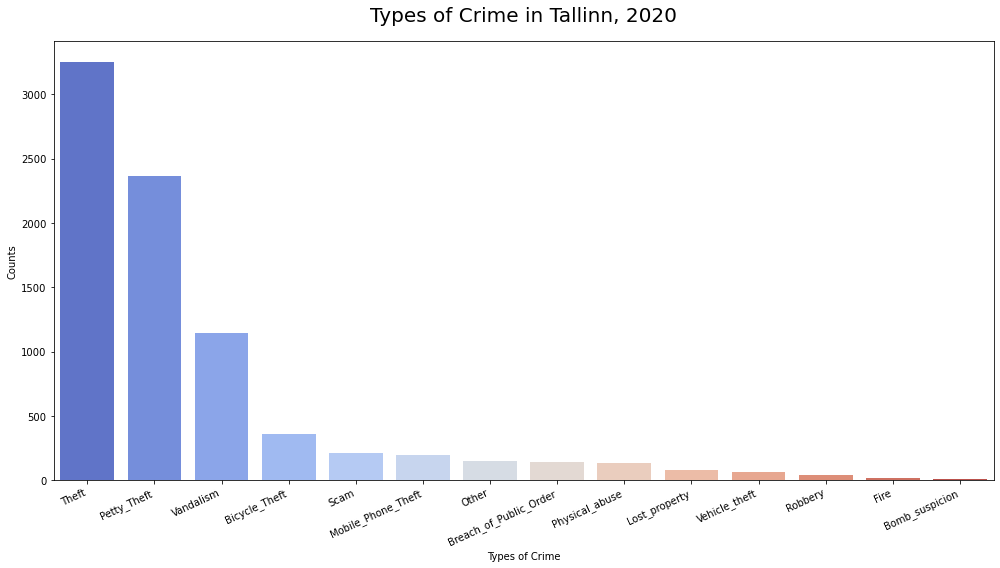

In [466]:
# now let's see the distribution of crimes between the types
plt.figure(figsize=(14,8))
plt.title('Types of Crime in Tallinn, 2020',fontdict={'fontsize':'20'},pad=20)
ax = sns.countplot(x='CrimeType',data=df_crime,palette='coolwarm', order = df_crime['CrimeType'].value_counts().index)
ax.set(xlabel='Types of Crime')
ax.set(ylabel='Counts')
plt.setp(ax.get_xticklabels(), rotation=25, horizontalalignment='right')
plt.tight_layout()

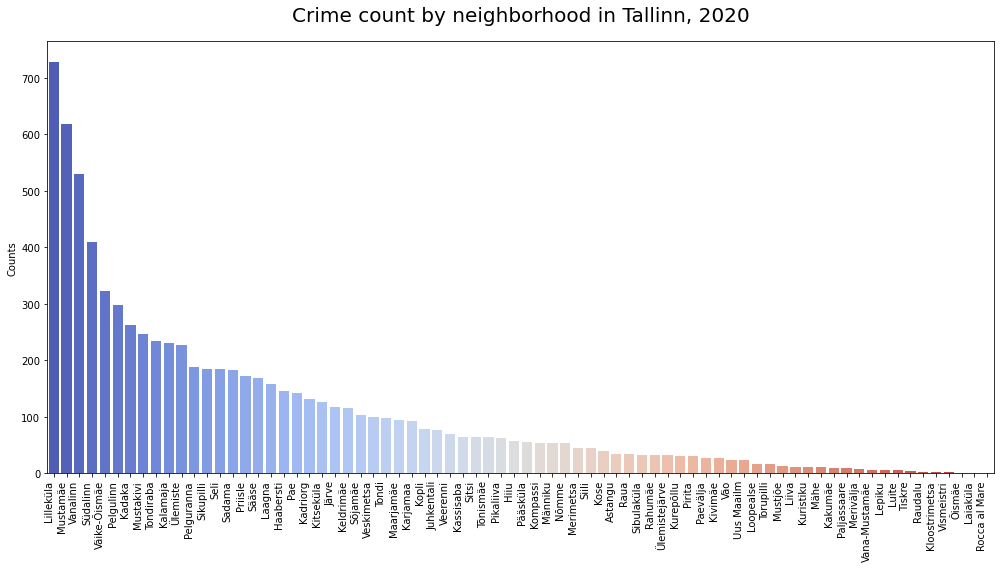

In [467]:
# also, let's check the distribution of crimes between the neighborhoods
plt.figure(figsize=(14,8))
plt.title('Crime count by neighborhood in Tallinn, 2020',fontdict={'fontsize':'20'},pad=20)
ax = sns.countplot(x='Neighborhood',data=crime_with_asumid,palette='coolwarm', order = crime_with_asumid['Neighborhood'].value_counts().index)
ax.set(xlabel='')
ax.set(ylabel='Counts')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.tight_layout()

In [468]:
# to show the crimes per neighborhood on choropleth map, we first need to create a respective geodataframe
df_data_map=gpd.GeoDataFrame(df_data)

<AxesSubplot:title={'center':'Number of crimes in neighborhoods of Tallinn'}>

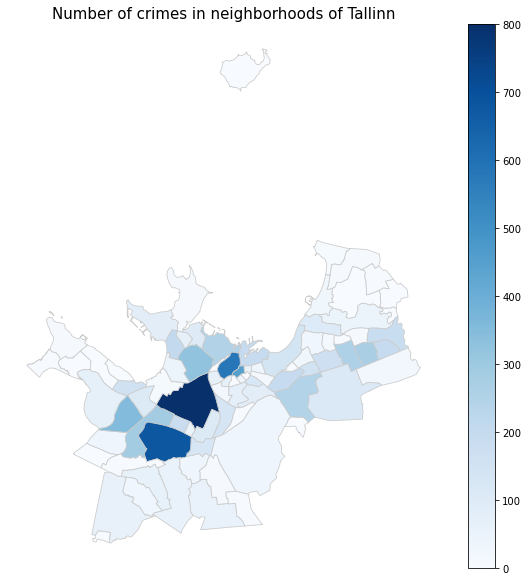

In [469]:
# now let's create the first choropleth map
# set a variable that will call whatever column we want to visualise on the map
variable = ('Crime_count')
# set the range for the choropleth
vmin, vmax = 0, 800
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 10))
# remove the axis
ax.axis('off')
# add a title
ax.set_title('Number of crimes in neighborhoods of Tallinn', fontdict={'fontsize': '15', 'fontweight' : '3'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
# create map
df_data_map.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Population of neighborhoods of Tallinn'}>

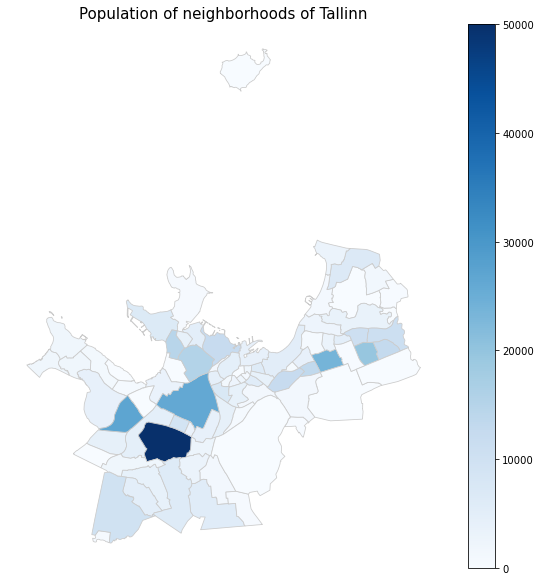

In [470]:
# now we'll create the map of neighborhood population
variable = ('Population')
vmin, vmax = 0, 50000
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Population of neighborhoods of Tallinn', fontdict={'fontsize': '15', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
df_data_map.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Density of neighborhoods of Tallinn'}>

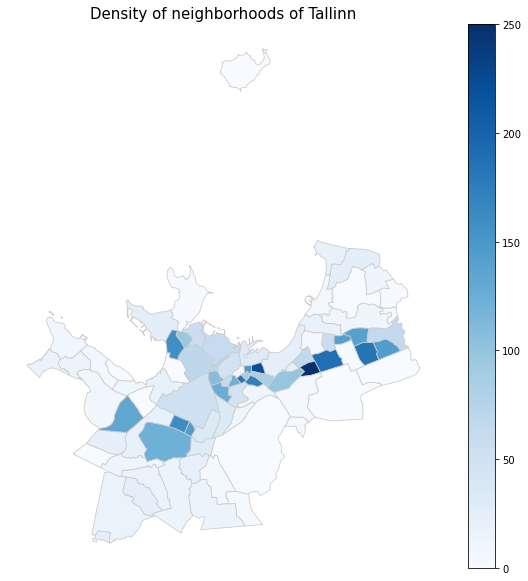

In [471]:
# next, map with neighborhood population density
variable = ('Density')
vmin, vmax = 0, 250
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Density of neighborhoods of Tallinn', fontdict={'fontsize': '15', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
df_data_map.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Monthly income of neighborhoods of Tallinn'}>

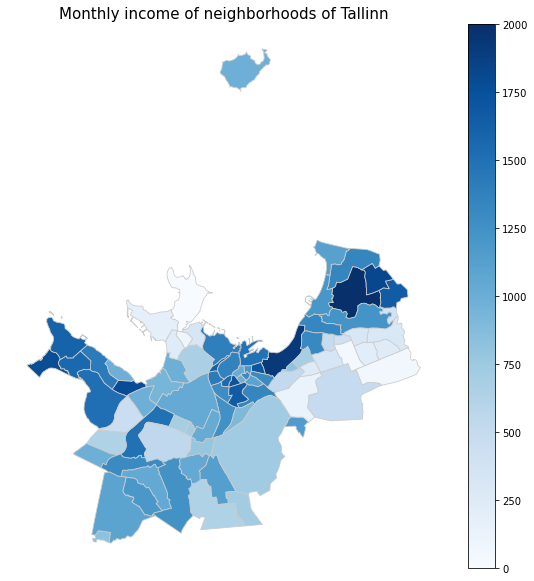

In [472]:
# and finally, choropleth on neighborhood incomes
variable = ('Income_monthly')
vmin, vmax = 0, 2000
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Monthly income of neighborhoods of Tallinn', fontdict={'fontsize': '15', 'fontweight' : '3'})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
df_data_map.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

(0.0, 949.4485305297785)

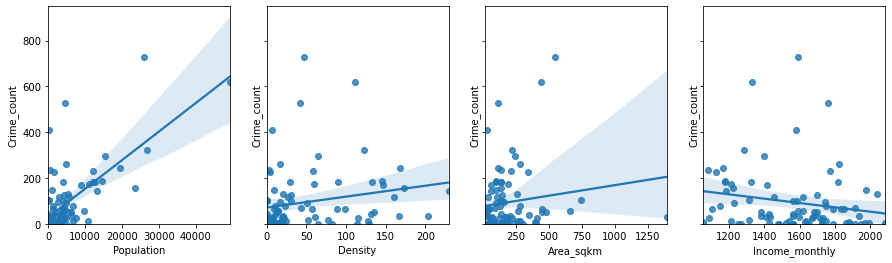

In [473]:
# final step of this section is to visualise and calculate the correlations between crime count and respectively population
# density, area and income. First, correlation scatterplots
fig, axes = plt.subplots(1,4,figsize=(15,4),sharey=True)
sns.regplot(x="Population",y="Crime_count",data=df_data,ax=axes[0])
sns.regplot(x="Density",y="Crime_count",data=df_data,ax=axes[1])
sns.regplot(x='Area_sqkm',y='Crime_count',data=df_data,ax=axes[2])
sns.regplot(x='Income_monthly',y='Crime_count',data=df_data,ax=axes[3])
plt.ylim(0,)

In [474]:
# and then, correlation and p-value calulations
pearson_coef, p_value = stats.pearsonr(df_data['Population'], df_data['Crime_count'])
print("Pearson correlation between population and crime count is", pearson_coef, "and P-value P =", p_value)
pearson_coef, p_value = stats.pearsonr(df_data['Density'], df_data['Crime_count'])
print("Pearson correlation between density and crime count is", pearson_coef, "and P-value P =", p_value)
pearson_coef, p_value = stats.pearsonr(df_data['Area_sqkm'], df_data['Crime_count'])
print("Pearson correlation between area and crime count is", pearson_coef, "and P-value P =", p_value)
pearson_coef, p_value = stats.pearsonr(df_data['Income_monthly'], df_data['Crime_count'])
print("Pearson correlation between income and crime count is", pearson_coef, "and P-value P =", p_value)

Pearson correlation between population and crime count is 0.6889690288839252 and P-value P = 4.3390895837573414e-13
Pearson correlation between density and crime count is 0.20008458035572396 and P-value P = 0.06802697271631018
Pearson correlation between area and crime count is 0.13534320319764231 and P-value P = 0.21963040166596942
Pearson correlation between income and crime count is -0.18390607700334088 and P-value P = 0.09401528006109083


As we can see, the only strong and meaningful link is between the crime count and population size of a neighborhood. In the next step we'll proceed with the analysis of top 10 neighborhoods with the highest crime count and see, what illustrates these neighborhoods.

### 2. Analysis of top 10 neighborhoods by crime count

In this section we'll perform the analysis of selected neighborhoods, plot the on the map using Folium, exploring the most popular venues in these neighborhoods using Foursquare and clustering them using k-means.

In [475]:
# First, we'll create the separate dataframe with data of neighborhood with highest crime rate in descending order
most=df_data.sort_values(by='Crime_count',ascending=False).head(10)
df_most=pd.DataFrame(most)
df_most.drop(['linnaosa_l','Area_sqkm','Income_monthly','Density','geometry'],axis=1,inplace=True)
df_most.head(10)

Neighborhood       District   Latitude  Longitude  Population  Crime_count
29     Lilleküla     Kristiine   59.420076  24.708247       25940        728.0
41      Mustamäe       Mustamäe  59.400405  24.681088       49345        619.0
79      Vanalinn       Kesklinn  59.437876  24.743519        4658        530.0
66      Südalinn       Kesklinn  59.434423  24.752541         168        410.0
77  Väike-Õismäe     Haabersti   59.412688  24.645559       26769        322.0
49     Pelgulinn  Põhja-Tallinn  59.440319  24.711536       15336        297.0
7         Kadaka       Mustamäe  59.407763  24.656631        4781        263.0
40     Mustakivi       Lasnamäe  59.443644  24.874310       19434        246.0
70     Tondiraba       Lasnamäe  59.442285  24.858399         354        235.0
10      Kalamaja  Põhja-Tallinn  59.447065  24.733997       12179        230.0

In [476]:
# in order to define an instance of the geocoder, we need to define a user_agent. 
#We will name our agent <em>tln_explorer</em>, as shown below.
address = 'Tallinn, Estonia'
geolocator = Nominatim(user_agent="tln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Tallinn, Estonia are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Tallinn, Estonia are 59.4372155, 24.7453688.


In [477]:
# create a map of Tallinn with top 10 neighborhoods superimposed on top
map_tln = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lng, neighborhood in zip(df_most['Latitude'], df_most['Longitude'], df_most['Neighborhood']):
    label = ' {}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tln)  
    
map_tln

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [478]:
CLIENT_ID = 'VYF54PM43JK31WBQFCMOGAU0G00Y3UWAOOM2WNOZVPTI3DAC' # your Foursquare ID
CLIENT_SECRET = 'DUGEXCOTFFWQLJCWF2FMEACR0C0OXVJCIIT5OCJRVCFL5RCZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VYF54PM43JK31WBQFCMOGAU0G00Y3UWAOOM2WNOZVPTI3DAC
CLIENT_SECRET:DUGEXCOTFFWQLJCWF2FMEACR0C0OXVJCIIT5OCJRVCFL5RCZ


In [479]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [480]:
df_most_venues = getNearbyVenues(names=df_most['Neighborhood'],
                                   latitudes=df_most['Latitude'],
                                   longitudes=df_most['Longitude']
                                  )

Lilleküla
Mustamäe
Vanalinn
Südalinn
Väike-Õismäe
Pelgulinn
Kadaka
Mustakivi
Tondiraba
Kalamaja


In [481]:
# let's check the size of the resulting dataframe
print(df_most_venues.shape)
df_most_venues.head()

(296, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Lilleküla              59.420076               24.708247   
1    Lilleküla              59.420076               24.708247   
2     Mustamäe              59.400405               24.681088   
3     Mustamäe              59.400405               24.681088   
4     Mustamäe              59.400405               24.681088   

                         Venue  Venue Latitude  Venue Longitude  \
0  Pihlaka kohvik ja kondiiter       59.416125        24.709683   
1                    Batmobiil       59.416169        24.709352   
2                   Männi park       59.398258        24.676693   
3              YEInternational       59.398020        24.677960   
4                Mustamäe Turg       59.403142        24.686268   

          Venue Category  
0                   Café  
1  Outdoors & Recreation  
2                   Park  
3      Electronics Store  
4         Farmers Market

In [482]:
# let's check how many venues were returned for each neighborhood
df_most_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                         
Kadaka                           15                      15     15   
Kalamaja                         10                      10     10   
Lilleküla                         2                       2      2   
Mustakivi                        11                      11     11   
Mustamäe                         14                      14     14   
Pelgulinn                        13                      13     13   
Südalinn                        100                     100    100   
Tondiraba                        23                      23     23   
Vanalinn                        100                     100    100   
Väike-Õismäe                      8                       8      8   

              Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                   
Kadaka                    15               15              15  
Kalamaja                  10               10              10  
Lilleküla                  2                2               2  
Mustakivi                 11               11              11  
Mustamäe                  14               14              14  
Pelgulinn                 13               13              13  
Südalinn                 100              100             100  
Tondiraba                 23               23              23  
Vanalinn                 100              100             100  
Väike-Õismäe               8                8               8

In [483]:
# analyze each neighborhood
# one hot encoding
tln_onehot = pd.get_dummies(df_most_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tln_onehot['Neighborhood'] = df_most_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tln_onehot.columns[-1]] + list(tln_onehot.columns[:-1])
tln_onehot = tln_onehot[fixed_columns]

tln_onehot.head()

Neighborhood  Arcade  Art Gallery  Art Museum  Arts & Crafts Store  \
0    Lilleküla       0            0           0                    0   
1    Lilleküla       0            0           0                    0   
2     Mustamäe       0            0           0                    0   
3     Mustamäe       0            0           0                    0   
4     Mustamäe       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Garage  BBQ Joint  Bakery  ...  \
0                 0                   0            0          0       0  ...   
1                 0                   0            0          0       0  ...   
2                 0                   0            0          0       0  ...   
3                 0                   0            0          0       0  ...   
4                 0                   0            0          0       0  ...   

   Tennis Stadium  Theater  Theme Restaurant  Tourist Information Center  \
0               0        0                 0                           0   
1               0        0                 0                           0   
2               0        0                 0                           0   
3               0        0                 0                           0   
4               0        0                 0                           0   

   Toy / Game Store  Trail  Ukrainian Restaurant  \
0                 0      0                     0   
1                 0      0                     0   
2                 0      0                     0   
3                 0      0                     0   
4                 0      0                     0   

   Vegetarian / Vegan Restaurant  Wine Bar  Wine Shop  
0                              0         0          0  
1                              0         0          0  
2                              0         0          0  
3                              0         0          0  
4                              0         0          0  

[5 rows x 114 columns]

In [484]:
tln_onehot.shape

(296, 114)

In [485]:
# next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
tln_grouped = tln_onehot.groupby('Neighborhood').mean().reset_index()
tln_grouped

Neighborhood    Arcade  Art Gallery  Art Museum  Arts & Crafts Store  \
0        Kadaka  0.066667         0.00        0.00             0.066667   
1      Kalamaja  0.000000         0.00        0.00             0.000000   
2     Lilleküla  0.000000         0.00        0.00             0.000000   
3     Mustakivi  0.000000         0.00        0.00             0.000000   
4      Mustamäe  0.000000         0.00        0.00             0.000000   
5     Pelgulinn  0.000000         0.00        0.00             0.000000   
6      Südalinn  0.000000         0.01        0.00             0.000000   
7     Tondiraba  0.000000         0.00        0.00             0.000000   
8      Vanalinn  0.000000         0.00        0.02             0.000000   
9  Väike-Õismäe  0.000000         0.00        0.00             0.000000   

   Asian Restaurant  Athletics & Sports  Auto Garage  BBQ Joint    Bakery  \
0          0.000000            0.000000     0.000000       0.00  0.133333   
1          0.000000            0.000000     0.000000       0.00  0.200000   
2          0.000000            0.000000     0.000000       0.00  0.000000   
3          0.000000            0.000000     0.000000       0.00  0.000000   
4          0.000000            0.071429     0.071429       0.00  0.000000   
5          0.000000            0.000000     0.000000       0.00  0.000000   
6          0.000000            0.000000     0.000000       0.00  0.010000   
7          0.043478            0.000000     0.000000       0.00  0.000000   
8          0.010000            0.000000     0.000000       0.02  0.010000   
9          0.000000            0.000000     0.000000       0.00  0.000000   

   ...  Tennis Stadium  Theater  Theme Restaurant  Tourist Information Center  \
0  ...        0.000000     0.00              0.00                        0.00   
1  ...        0.000000     0.10              0.00                        0.00   
2  ...        0.000000     0.00              0.00                        0.00   
3  ...        0.000000     0.00              0.00                        0.00   
4  ...        0.000000     0.00              0.00                        0.00   
5  ...        0.000000     0.00              0.00                        0.00   
6  ...        0.000000     0.02              0.02                        0.00   
7  ...        0.043478     0.00              0.00                        0.00   
8  ...        0.000000     0.04              0.02                        0.01   
9  ...        0.000000     0.00              0.00                        0.00   

   Toy / Game Store  Trail  Ukrainian Restaurant  \
0          0.000000    0.0              0.000000   
1          0.000000    0.1              0.000000   
2          0.000000    0.0              0.000000   
3          0.000000    0.0              0.000000   
4          0.000000    0.0              0.071429   
5          0.000000    0.0              0.000000   
6          0.010000    0.0              0.000000   
7          0.043478    0.0              0.000000   
8          0.000000    0.0              0.000000   
9          0.000000    0.0              0.000000   

   Vegetarian / Vegan Restaurant  Wine Bar  Wine Shop  
0                           0.00      0.00       0.00  
1                           0.00      0.00       0.00  
2                           0.00      0.00       0.00  
3                           0.00      0.00       0.00  
4                           0.00      0.00       0.00  
5                           0.00      0.00       0.00  
6                           0.00      0.01       0.01  
7                           0.00      0.00       0.00  
8                           0.01      0.03       0.00  
9                           0.00      0.00       0.00  

[10 rows x 114 columns]

In [486]:
tln_grouped.shape

(10, 114)

In [487]:
# let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in tln_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = tln_grouped[tln_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Kadaka----
               venue  freq
0             Bakery  0.13
1             Arcade  0.07
2         Bike Trail  0.07
3              Plaza  0.07
4  Electronics Store  0.07


----Kalamaja----
          venue  freq
0        Bakery   0.2
1           Bar   0.1
2    Playground   0.1
3        Market   0.1
4  Dance Studio   0.1


----Lilleküla----
                        venue  freq
0       Outdoors & Recreation   0.5
1                        Café   0.5
2                      Arcade   0.0
3  Modern European Restaurant   0.0
4                       Plaza   0.0


----Mustakivi----
                     venue  freq
0            Grocery Store  0.18
1  Comfort Food Restaurant  0.09
2               Restaurant  0.09
3        Indian Restaurant  0.09
4               Playground  0.09


----Mustamäe----
              venue  freq
0     Grocery Store  0.07
1  Basketball Court  0.07
2               Pub  0.07
3        Restaurant  0.07
4              Park  0.07


----Pelgulinn----
                  venue

In [488]:
# let's put that into a _pandas_ dataframe
# first, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [489]:
# now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tln_grouped['Neighborhood']

for ind in np.arange(tln_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tln_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

Neighborhood        1st Most Common Venue 2nd Most Common Venue  \
0        Kadaka                       Bakery                Arcade   
1      Kalamaja                       Bakery            Playground   
2     Lilleküla        Outdoors & Recreation                  Café   
3     Mustakivi                Grocery Store            Playground   
4      Mustamäe            Electronics Store           Auto Garage   
5     Pelgulinn                     Bus Stop              Bus Line   
6      Südalinn                        Hotel                  Café   
7     Tondiraba       Furniture / Home Store       Motorcycle Shop   
8      Vanalinn  Eastern European Restaurant            Restaurant   
9  Väike-Õismäe            Convenience Store              Bus Line   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0               Stadium         Grocery Store     Electronics Store   
1                Market                 Trail                  Park   
2             Wine Shop     Electronics Store          Concert Hall   
3            Restaurant                  Park  Fast Food Restaurant   
4      Doner Restaurant        Farmers Market            Restaurant   
5                  Café           Sports Club           Beer Garden   
6            Restaurant          Cocktail Bar  Gym / Fitness Center   
7           Bus Station           Supermarket          Home Service   
8        Scenic Lookout                 Hotel               Theater   
9         Grocery Store         Moving Target           Bus Station   

  6th Most Common Venue 7th Most Common Venue        8th Most Common Venue  \
0      Department Store           Coffee Shop                  Pizza Place   
1         Indie Theater               Theater                 Dance Studio   
2     Convenience Store        Cosmetics Shop                     Creperie   
3                   Bar     Indian Restaurant      Comfort Food Restaurant   
4     Food & Drink Shop      Basketball Court                          Pub   
5           Supermarket  Fast Food Restaurant                  Bus Station   
6        Cosmetics Shop    Italian Restaurant                       Hostel   
7         Shopping Mall                   Gym                  Flower Shop   
8           Coffee Shop          Cocktail Bar                         Park   
9          Liquor Store             Wine Shop  Eastern European Restaurant   

  9th Most Common Venue       10th Most Common Venue  
0          Camera Store                  Bus Station  
1                   Bar                    Wine Shop  
2          Cupcake Shop                 Dance Studio  
3                   Gym                    Pool Hall  
4           Bus Station           Athletics & Sports  
5            Skate Park                  Pizza Place  
6           Coffee Shop                Movie Theater  
7     Electronics Store  Eastern European Restaurant  
8                 Plaza   Modern European Restaurant  
9        Cosmetics Shop                     Creperie

#### Clustering neighborhoods using k-means

In [490]:
# run _k_-means to cluster the neighborhood into 5 clusters.
# set number of clusters
kclusters = 5

tln_grouped_clustering = tln_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tln_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([2, 0, 1, 2, 2, 4, 2, 2, 2, 3], dtype=int32)

In [491]:
# let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tln_merged = df_most

# merge tln_grouped with tln_data to add latitude/longitude for each neighborhood
tln_merged = tln_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tln_merged.head(10)

Neighborhood       District   Latitude  Longitude  Population  \
29     Lilleküla     Kristiine   59.420076  24.708247       25940   
41      Mustamäe       Mustamäe  59.400405  24.681088       49345   
79      Vanalinn       Kesklinn  59.437876  24.743519        4658   
66      Südalinn       Kesklinn  59.434423  24.752541         168   
77  Väike-Õismäe     Haabersti   59.412688  24.645559       26769   
49     Pelgulinn  Põhja-Tallinn  59.440319  24.711536       15336   
7         Kadaka       Mustamäe  59.407763  24.656631        4781   
40     Mustakivi       Lasnamäe  59.443644  24.874310       19434   
70     Tondiraba       Lasnamäe  59.442285  24.858399         354   
10      Kalamaja  Põhja-Tallinn  59.447065  24.733997       12179   

    Crime_count  Cluster Labels        1st Most Common Venue  \
29        728.0               1        Outdoors & Recreation   
41        619.0               2            Electronics Store   
79        530.0               2  Eastern European Restaurant   
66        410.0               2                        Hotel   
77        322.0               3            Convenience Store   
49        297.0               4                     Bus Stop   
7         263.0               2                       Bakery   
40        246.0               2                Grocery Store   
70        235.0               2       Furniture / Home Store   
10        230.0               0                       Bakery   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
29                  Café             Wine Shop     Electronics Store   
41           Auto Garage      Doner Restaurant        Farmers Market   
79            Restaurant        Scenic Lookout                 Hotel   
66                  Café            Restaurant          Cocktail Bar   
77              Bus Line         Grocery Store         Moving Target   
49              Bus Line                  Café           Sports Club   
7                 Arcade               Stadium         Grocery Store   
40            Playground            Restaurant                  Park   
70       Motorcycle Shop           Bus Station           Supermarket   
10            Playground                Market                 Trail   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
29          Concert Hall     Convenience Store        Cosmetics Shop   
41            Restaurant     Food & Drink Shop      Basketball Court   
79               Theater           Coffee Shop          Cocktail Bar   
66  Gym / Fitness Center        Cosmetics Shop    Italian Restaurant   
77           Bus Station          Liquor Store             Wine Shop   
49           Beer Garden           Supermarket  Fast Food Restaurant   
7      Electronics Store      Department Store           Coffee Shop   
40  Fast Food Restaurant                   Bar     Indian Restaurant   
70          Home Service         Shopping Mall                   Gym   
10                  Park         Indie Theater               Theater   

          8th Most Common Venue 9th Most Common Venue  \
29                     Creperie          Cupcake Shop   
41                          Pub           Bus Station   
79                         Park                 Plaza   
66                       Hostel           Coffee Shop   
77  Eastern European Restaurant        Cosmetics Shop   
49                  Bus Station            Skate Park   
7                   Pizza Place          Camera Store   
40      Comfort Food Restaurant                   Gym   
70                  Flower Shop     Electronics Store   
10                 Dance Studio                   Bar   

         10th Most Common Venue  
29                 Dance Studio  
41           Athletics & Sports  
79   Modern European Restaurant  
66                Movie Theater  
77                     Creperie  
49                  Pizza Place  
7                   Bus Station  
40                    Pool Hall  
70  Eastern Europea

In [492]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tln_merged['Latitude'], tln_merged['Longitude'], tln_merged['Neighborhood'], tln_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examining clusters

In [493]:
tln_merged.loc[tln_merged['Cluster Labels'] == 0, tln_merged.columns[[1] + list(range(5, tln_merged.shape[1]))]]

District  Crime_count  Cluster Labels 1st Most Common Venue  \
10  Põhja-Tallinn        230.0               0                Bakery   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
10            Playground                Market                 Trail   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
10                  Park         Indie Theater               Theater   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
10          Dance Studio                   Bar              Wine Shop

In [494]:
tln_merged.loc[tln_merged['Cluster Labels'] == 1, tln_merged.columns[[1] + list(range(5, tln_merged.shape[1]))]]

District  Crime_count  Cluster Labels  1st Most Common Venue  \
29  Kristiine         728.0               1  Outdoors & Recreation   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
29                  Café             Wine Shop     Electronics Store   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
29          Concert Hall     Convenience Store        Cosmetics Shop   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
29              Creperie          Cupcake Shop           Dance Studio

In [495]:
tln_merged.loc[tln_merged['Cluster Labels'] == 2, tln_merged.columns[[1] + list(range(5, tln_merged.shape[1]))]]

District  Crime_count  Cluster Labels        1st Most Common Venue  \
41  Mustamäe        619.0               2            Electronics Store   
79  Kesklinn        530.0               2  Eastern European Restaurant   
66  Kesklinn        410.0               2                        Hotel   
7   Mustamäe        263.0               2                       Bakery   
40  Lasnamäe        246.0               2                Grocery Store   
70  Lasnamäe        235.0               2       Furniture / Home Store   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
41           Auto Garage      Doner Restaurant        Farmers Market   
79            Restaurant        Scenic Lookout                 Hotel   
66                  Café            Restaurant          Cocktail Bar   
7                 Arcade               Stadium         Grocery Store   
40            Playground            Restaurant                  Park   
70       Motorcycle Shop           Bus Station           Supermarket   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
41            Restaurant     Food & Drink Shop      Basketball Court   
79               Theater           Coffee Shop          Cocktail Bar   
66  Gym / Fitness Center        Cosmetics Shop    Italian Restaurant   
7      Electronics Store      Department Store           Coffee Shop   
40  Fast Food Restaurant                   Bar     Indian Restaurant   
70          Home Service         Shopping Mall                   Gym   

      8th Most Common Venue 9th Most Common Venue       10th Most Common Venue  
41                      Pub           Bus Station           Athletics & Sports  
79                     Park                 Plaza   Modern European Restaurant  
66                   Hostel           Coffee Shop                Movie Theater  
7               Pizza Place          Camera Store                  Bus Station  
40  Comfort Food Restaurant                   Gym                    Pool Hall  
70              Flower Shop     Electronics Store  Eastern European Restaurant

In [496]:
tln_merged.loc[tln_merged['Cluster Labels'] == 3, tln_merged.columns[[1] + list(range(5, tln_merged.shape[1]))]]

District  Crime_count  Cluster Labels 1st Most Common Venue  \
77  Haabersti         322.0               3     Convenience Store   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
77              Bus Line         Grocery Store         Moving Target   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
77           Bus Station          Liquor Store             Wine Shop   

          8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
77  Eastern European Restaurant        Cosmetics Shop               Creperie

In [497]:
tln_merged.loc[tln_merged['Cluster Labels'] == 4, tln_merged.columns[[1] + list(range(5, tln_merged.shape[1]))]]

District  Crime_count  Cluster Labels 1st Most Common Venue  \
49  Põhja-Tallinn        297.0               4              Bus Stop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
49              Bus Line                  Café           Sports Club   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
49           Beer Garden           Supermarket  Fast Food Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
49           Bus Station            Skate Park            Pizza Place